In [52]:
%matplotlib ipympl

from ipywidgets import *

import sys
from time import time
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D, art3d

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75

import xml.etree.ElementTree as ET
import h5py

from importlib import reload

import utils

sys.path.append('/Users/patrickoare/lqcd/utilities')
# import pytools as pyt
import plottools as pt
import formattools as fmt
pt.set_font()
default_style = fmt.styles['notebook']

import GCR

In [4]:
def get_poly_approx(coeffs):
    """
    Returns a polynomial series with the coefficients given by coeffs. 
    """
    def f(x):
        tmp = 0.
        for n in range(len(coeffs)):
            tmp += coeffs[n] * (x**n)           # return c_i x^i (starting with i=0, c_0 = coeffs[1])
        return tmp
    return f

## Testing

In [5]:
# # read coeffs
# coeffs = [0.10659748, -0.001731329, 1.0303392e-05, -2.9728492e-08]                  # output of CGPolynomial
# # coeffs = [0.10800582, -0.003537117, 0.00065907613, -0.00068003893, 0.0001078631, -7.5830468e-06, 2.8589633e-07]       # current output of my code
# approx = get_poly_approx(coeffs)
# norm = sum(coeffs)     # normalization for 1/x at x = 1

In [6]:
# xx = np.linspace(0.00001, 10, num = 1000)
# xx_inv = norm / xx                   # true 1/x
# xx_poly = approx(xx)         # approx 1/x

In [7]:
# fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$')
# pt.plot_1d_data(xx, xx_poly, ax = ax, col = pt.pal[1], linestyle = '--', fn_label = r'$\psi_*^n$', ax_label = [r'$x$', r'$\frac{1}{x}$'], title = r'Krylov approximation')
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

## Compare with Christoph's Method

#### Generating vectors in the deflation basis
Generate Gaussian source field $b\sim \mathcal N$. 
1. Standard method: inverse iteration on $b$, i.e. solve $D\psi = b$ for some number of iterations (possibly iterate this and solve $D^n \psi = b$). The resulting $\psi$ should be rich in low modes. 
2. Christoph's proposed method: use $\psi_0 = b$ as a starting guess, and relax on this initial guess for some number of iterations, i.e. solve $D\psi = 0$ with $\psi_0 = b$. 

In [8]:
# # LAMBDA_MIN = 1e-5
# # # LAMBDA_MIN = 1e-12
# # LAMBDA_MAX = 100
# # xx = np.linspace(LAMBDA_MIN, LAMBDA_MAX, num = NLAMBDA)

# LAMBDA_MIN_PWR = -5
# LAMBDA_MAX_PWR = 2
# NLAMBDA = 10000

# LAMBDA_MIN = 10**LAMBDA_MIN_PWR
# LAMBDA_MAX = 10**LAMBDA_MAX_PWR

# xx = np.logspace(LAMBDA_MIN_PWR, LAMBDA_MAX_PWR, num = NLAMBDA)

In [9]:
# s_str = '(4.89467324,-4.63084243e-06) (-1.70519353,1.60703321e-07) (0.291209207,3.68285385e-07) (-0.0282229029,-7.86537838e-08) (0.00167111438,7.31382187e-09) (-6.25334376e-05,-3.75778427e-10) (1.48327458e-06,1.13884404e-11) (-2.1599485e-08,-2.02575489e-13) (1.76003458e-10,1.95498723e-15) (-6.13978636e-13,-7.89624602e-18)'
# c_str = '(3.30978151,0.000235574671) (-1.73329652,-0.000121847507) (0.353321046,2.50819331e-05) (-0.0377727529,-2.7927669e-06) (0.00237868533,1.87407811e-07) (-9.28123894e-05,-7.89692312e-09) (2.26847461e-06,2.09814358e-10) (-3.37807191e-08,-3.40462427e-12) (2.80040029e-10,3.0760939e-14) (-9.90247986e-13,-1.18441804e-16)'
# s_coeffs = np.array(x for x in [s_str.split(')')[:-1], dtype = np.complex64)

In [10]:
# s_coeffs = [(4.89467324,-4.63084243e-06), (-1.70519353,1.60703321e-07), (0.291209207,3.68285385e-07), (-0.0282229029,-7.86537838e-08), 
#              (0.00167111438,7.31382187e-09), (-6.25334376e-05,-3.75778427e-10), (1.48327458e-06,1.13884404e-11), (-2.1599485e-08,-2.02575489e-13), 
#              (1.76003458e-10,1.95498723e-15), (-6.13978636e-13,-7.89624602e-18)]       # standard coefficients
# # c_coeffs = [(3.30978151,0.000235574671), (-1.73329652,-0.000121847507), (0.353321046,2.50819331e-05), (-0.0377727529,-2.7927669e-06),
# #               (0.00237868533,1.87407811e-07), (-9.28123894e-05,-7.89692312e-09), (2.26847461e-06,2.09814358e-10), 
# #               (-3.37807191e-08,-3.40462427e-12), (2.80040029e-10,3.0760939e-14), (-9.90247986e-13,-1.18441804e-16)]      # christoph coeffs
# c_coeffs = [(9.24765674,-6.15114902e-12), (-5.97251947,-7.48977389e-05), (1.49842984,3.57347531e-05), (-0.198251807,-6.80097961e-06), (0.0156518458,6.92067703e-07),
#             (-0.000782795535,-4.21136563e-08), (2.54217712e-05,1.60661046e-09), (-5.34369624e-07,-3.8747931e-11), (7.01056551e-09,5.73502463e-13), 
#             (-5.2153555e-11,-4.75259232e-15), (1.67912235e-13,1.68768798e-17)]
# s_coeffs = np.array([x+1j*y for (x, y) in s_coeffs], dtype = np.complex64)
# c_coeffs = np.array([x+1j*y for (x, y) in c_coeffs], dtype = np.complex64)

# # normalize all coeffs so f(1) = 1
# s_norm = sum(s_coeffs.real)
# c_norm = sum(c_coeffs.real)
# # s_coeffs /= s_norm
# # c_coeffs /= c_norm

In [11]:
# print('----------------------------------------')
# print('------ REAL PARTS OF POLY COEFFS -------')
# print('----------------------------------------')
# print(s_coeffs.real)
# print(c_coeffs.real)
# print()

# print('----------------------------------------')
# print('---- IMAGINARY PARTS OF POLY COEFFS ----')
# print('----------------------------------------')
# print(s_coeffs.imag)
# print(c_coeffs.imag)

In [12]:
# s_approx = get_poly_approx(s_coeffs)
# c_approx = get_poly_approx(c_coeffs)

In [13]:
# xx_inv = 1 / xx                   # true 1/x
# s_poly = s_approx(xx)         # approx 1/x
# s_poly_orig = s_poly
# c_poly = c_approx(xx)

In [14]:
# # normalize so f(1) = 1
# s_poly /= s_norm
# c_poly /= c_norm

Polynomial approximation to $1/x$ from GCR with 10 iterations (no restarts). Currently normalized by specifying $q(1) = 1$. 

In [15]:
# fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$')

# # red point at normalization
# mstyle = default_style.copy()
# mstyle['markersize'] = 100
# pt.scatter_1d([1], [1], ax = ax, col = pt.pal[3], style = mstyle, fn_label = 'Normalization', zorder = 100)

# pt.plot_1d_data(xx, np.real(s_poly), ax = ax, col = pt.pal[1], linestyle = '--', fn_label = r'Standard')
# pt.plot_1d_data(xx, np.real(c_poly), ax = ax, col = pt.pal[2], linestyle = ':', fn_label = r'Christoph', ax_label = [r'$x$', r'$\frac{1}{x}$'], title = r'$10^\mathrm{th}$ order Krylov approximation')

# # ax.set_yscale('log')
# ax.set_xlim((0.01, 10))
# ax.set_ylim((-0.5, 10))
# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

In [16]:
# fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$')
# pt.scatter_1d([1], [1], ax = ax, col = pt.pal[3], style = mstyle, fn_label = 'Normalization', zorder = 100)
# pt.plot_1d_data(xx, np.real(s_poly), ax = ax, col = pt.pal[1], linestyle = '--', fn_label = r'Standard')
# pt.plot_1d_data(xx, np.real(c_poly), ax = ax, col = pt.pal[2], linestyle = ':', fn_label = r'Christoph', ax_label = [r'$x$', r'$\frac{1}{x}$'], title = r'$10^\mathrm{th}$ order Krylov approximation')
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

In [17]:
# eps = 1e-8
# zx = np.linspace(eps, 10, 100)
# # zy = np.linspace(eps, 1, 100)
# zy = np.linspace(-1, 1, 200)
# zxx, zyy = np.meshgrid(zx, zy)
# z = zxx + 1j*zyy

In [18]:
# s_complex_poly = s_approx(z)
# c_complex_poly = c_approx(z)
# # s_complex_poly = 1 - z*s_approx(z)
# # c_complex_poly = 1 - z*c_approx(z)
# z_inv = 1 / z

In [19]:
# # which part of the complex function to plot
# plot_filter = np.abs
# scale = np.log
# # plot_filter = np.imag
# # scale = lambda x : x        # identity scale

In [20]:
# fig_size = (default_style['colwidth'], default_style['colwidth'] / default_style['asp_ratio'])
# fig = plt.figure(figsize = fig_size)
# ax = fig.add_subplot(projection='3d')
# graph = ax.plot_surface(zxx, zyy, scale(plot_filter(z_inv)), cmap = 'hot')
# ax.set_title(r'$\frac{1}{z}$')
# ax.set_xlabel(r'$\mathrm{re}\, z$')
# ax.set_ylabel(r'$\mathrm{im}\, z$')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

In [21]:
# fig_size = (default_style['colwidth'], default_style['colwidth'] / default_style['asp_ratio'])
# fig = plt.figure(figsize = fig_size)
# ax = fig.add_subplot(projection='3d')
# graph = ax.plot_surface(zxx, zyy, scale(plot_filter(s_complex_poly)), cmap = 'hot')
# ax.set_title(r'Inverse iteration on Gaussian Noise')
# ax.set_xlabel(r'$\mathrm{re}\, z$')
# ax.set_ylabel(r'$\mathrm{im}\, z$')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# # ax.xaxis._axinfo['juggled'] = (0,0,0)
# # ax.yaxis._axinfo['juggled'] = (1,1,1)
# # ax.zaxis._axinfo['juggled'] = (2,2,2)

In [22]:
# fig = plt.figure(figsize = fig_size)
# ax = fig.add_subplot(projection='3d')
# graph = ax.plot_surface(zxx, zyy, scale(plot_filter(c_complex_poly)), cmap = 'hot')
# ax.set_title(r'Relaxing on Gaussian Noise')
# ax.set_xlabel(r'$\mathrm{re}\, z$')
# ax.set_ylabel(r'$\mathrm{im}\, z$')
# ax.set_zlabel(r'$\log q_n(z)$')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Plot GCR polynomial in the complex plane

### Automated GCR Coeffs for $n_{itr} = 1 : 200$

Given a (preconditioned) Dirac operator $D$, Generalized Conjugate Residual (GCR) is a Krylov space solver that allows for non-Hermitian $D$ and solves the Dirac equation with source $b$,
$$
    D\psi = b
$$
We start with an initial guess $\psi_0 = 0$, and I typically denote the resulting fermion field after the solve by $\psi_*$, which we see satisfies $\psi_*\approx D^{-1} b$ (here $\psi_* = \psi_n$, where $n$ is the maximum number of iterations and $\psi_k$ tracks the iterate fermion field at iteration $k$). We can view GCR (and any Krylov solver) as producing an approximation for the inverse Dirac matrix in the Krylov space generated by the initial residual $r_0 = b - D\psi_0 = b$,
$$
    D^{-1} b \approx \psi_* = \sum_{k=0}^n c_k D^k b = q_n(D) b \in K_n(D, b),
$$
where $n$ is the number of iterations the algorithm is run with. We can see where in the spectrum of $D$ this polynomial approximation works well by viewing it as a polynomial over the complex numbers, $q_n(z)$,
$$
    q_n(z) = \sum_{k=0}^n c_k z^k \approx z^{-1}.
$$
The fidelity of the approximation is seen by how well $q_n(z)$ approximates $1/z$, and in what regions of the spectrum it well approximates $1/z$. 

GCR updates the fermion field $\psi_k$, along with the residual $r_k$ and a basis $\{p_i\}_{i\leq k}$ of momentum vectors which are $D^\dagger D$ conjugate. 
$$
	\psi_{k+1} \longrightarrow \psi_k + \alpha_k p_k \\
	r_{k+1} \longrightarrow r_k - \alpha_k D p_k \\
	p_{k+1} \longrightarrow p_k + \sum_{i=0}^k \beta_{ik} p_i.
$$
Here the $\alpha_k$ and $\beta_{ik}$ coefficients are functions of these fields and computed by the algorithm. Each of the fields lies in the Krylov space $K_n(D, r_0)$, and the coefficients $(c_k)_{k=1}^n$ of the polynomial $q_n(z)$ are exactly the coefficients of $\psi_n$ in the Krylov basis
$$
	\mathcal B = \{b, Db, D^2 b, ..., D^n b\}.
$$
We can thus represent $\psi_k(x)$, $r_k(x)$, and $p_k(x)$ as $(k+1)$-dimensional vectors in the canonical Krylov basis $\mathcal B$, so for example $\psi_1 = (2, 5)$ denotes the vector $\psi_1 = 2b + 5 Db$, and so on. The convenient thing about this basis is that the action of $D$ on a vector simply shifts the coefficients to the right, so for this choice of $\psi_1$ note that $D\psi_1 = (0, 2, 5) = 2 Db + 5 D^2 b$. We can then run the GCR algorithm but also track these fields in terms of their coefficients in this basis, where the action of $D$ shifts the vector to the right. Note that the initial conditions of $\psi_0 = 0$ and $r_0 = p_0 = b$ are represented in the Krylov basis as $\psi_0 = ()$, the null vector, and $r_0 = p_0 = (1)$. After running GCR with these inputs, the resulting vector components of the vector $\psi_*$ are then exactly the coefficients $(c_k)$ of $q_n(z)$. 

Suppose we fix $z\in \mathbb C$. A potential problem is that storing these coefficients and directly computing $q_n(z)$ at large $n$ ($n\geq 20$-ish?) can be numerically unstable, since it's a very large degree polynomial, so we start to run into fine-tuning problems if we directly compute the coefficients and then simply plot the polynomial (especially at large $z$). So, an alternate way to compute $q_n(z)$ for moderate to large $n$ is to store the $\alpha$ and $\beta$ coefficients and then to store $\psi$, $r$, and $p$ as elements of the polynomial ring $\mathbb C[z]$, i.e. as formal linear combinations of $z^k$. In the update scheme, this identification replaces the action of $D$ on a field with a multiplication by $z$ in the polynomial ring, and starts with the initial polynomials $\psi_0 = 0$ and $r_0 = p_0 = 1$, with the following updates,
$$
	\psi_{k+1} \longrightarrow \psi_k + \alpha_k p_k \\
	r_{k+1} \longrightarrow r_k - \alpha_k z p_k \\
	p_{k+1} \longrightarrow p_k + \sum_{i=0}^k \beta_{ik} p_i.
$$
Note that this requires performing the entire update scheme for each $z$ that we wish to examine, so it is slower than the initial method which precomputes the polynomial coefficients. However, it is numerically much more stable, because it does not require any fine tuning. 

In [23]:
def parse_h5_input(grp):
    data = {}
    data['alphas'] = grp['alphas'][()]
    data['coeffs'] = grp['coeffs'][()]
    data['betas'] = []
    for ii in range(len(grp['betas'])):
        data['betas'].append(
            grp[f'betas/{ii}'][()]
        )
    return data

In [24]:
# file = '/Users/patrickoare/Dropbox (MIT)/research/multigrid/gcr_coeffs/run1/parsed_data.h5'
file = '/Users/patrickoare/Dropbox (Personal)/research/multigrid/gcr_coeffs/run2/parsed_data.h5'
f = h5py.File(file, 'r')
# inv = parse_h5_input(f['invert_50'])
# relax = parse_h5_input(f['relax_50'])
inv = parse_h5_input(f['invert_200'])
relax = parse_h5_input(f['relax_200'])
f.close()

In [25]:
poly_inv   = [get_poly_approx(coeffs) for coeffs in inv['coeffs']]
poly_relax = [get_poly_approx(coeffs) for coeffs in relax['coeffs']]

max_itr = len(poly_inv)
print(f'GCR ran with {max_itr} iterations.')

GCR ran with 200 iterations.


In [26]:
LAMBDA_MIN_PWR = -2
LAMBDA_MAX_PWR = 3
NLAMBDA = 10000

LAMBDA_MIN = 10**LAMBDA_MIN_PWR
LAMBDA_MAX = 10**LAMBDA_MAX_PWR

xx = np.logspace(LAMBDA_MIN_PWR, LAMBDA_MAX_PWR, num = NLAMBDA)
xx_inv = 1 / xx

# unnormalized
poly_inv_xx = [poly(xx) for poly in poly_inv]
poly_relax_xx = [poly(xx) for poly in poly_relax]

# normalized
# poly_inv_xx = [poly(xx) / sum(inv[ii]) for ii, poly in enumerate(poly_inv)]
# poly_relax_xx = [poly(xx) / sum(relax[ii]) for ii, poly in enumerate(poly_relax)]

/var/folders/4q/v1ykxzz94sn6ms0kkh0gm8880000gr/T/ipykernel_95588/2191329783.py:8: RuntimeWarning: overflow encountered in power
  tmp += coeffs[n] * (x**n)           # return c_i x^i (starting with i=0, c_0 = coeffs[1])
/var/folders/4q/v1ykxzz94sn6ms0kkh0gm8880000gr/T/ipykernel_95588/2191329783.py:8: RuntimeWarning: invalid value encountered in multiply
  tmp += coeffs[n] * (x**n)           # return c_i x^i (starting with i=0, c_0 = coeffs[1])


#### With direct coefficient calculation

In [27]:
int_style = default_style.copy()
int_style['colwidth'] = 10

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update0(n=0)>

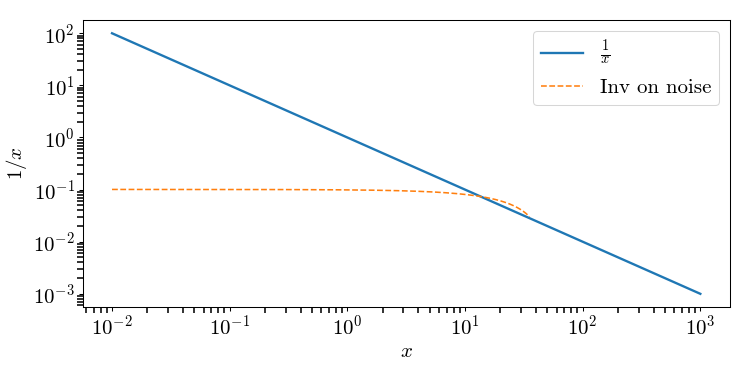

In [28]:
fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$', style = int_style)

line0, = ax.plot(xx, np.abs(poly_inv_xx[0]), color = pt.pal[1], linestyle = '--', label = 'Inv on noise')
def update0(n=0):
    line0.set_ydata(np.real(poly_inv_xx[n]))
    fig.canvas.draw_idle()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$x$', fontsize = default_style['fontsize'])
ax.set_ylabel(r'$1/x$', fontsize = default_style['fontsize'])
# ax.set_xlim((0.01, 10))
# ax.set_ylim((-0.5, 10))
plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

interact(update0, n = (1, max_itr - 1, 1))

#### With calculation of the polynomial directly from $(\alpha_i, \beta_{ij})$

In [29]:
GCRinv = GCR.PolyGCR(inv['alphas'], inv['betas'])

In [30]:
poly_inv_GCR_xx = np.zeros((max_itr, len(xx)), dtype = np.complex64)
for ii, x in enumerate(xx):
    px = GCRinv.eval_poly_stable(x, store_all = True)
    poly_inv_GCR_xx[:, ii] = px

/var/folders/4q/v1ykxzz94sn6ms0kkh0gm8880000gr/T/ipykernel_95588/2608319223.py:4: RuntimeWarning: overflow encountered in cast
  poly_inv_GCR_xx[:, ii] = px
/Users/patrickoare/lqcd/multigrid/python_scripts/GCR.py:194: RuntimeWarning: overflow encountered in scalar multiply
  r     = r - alpha * x * p[j]
/Users/patrickoare/lqcd/multigrid/python_scripts/GCR.py:194: RuntimeWarning: invalid value encountered in scalar subtract
  r     = r - alpha * x * p[j]
/Users/patrickoare/lqcd/multigrid/python_scripts/GCR.py:201: RuntimeWarning: invalid value encountered in scalar add
  pnew += beta[i] * p[i]
/Users/patrickoare/lqcd/multigrid/python_scripts/GCR.py:191: RuntimeWarning: invalid value encountered in scalar multiply
  psi   = psi + alpha * p[j]
/Users/patrickoare/lqcd/multigrid/python_scripts/GCR.py:194: RuntimeWarning: invalid value encountered in scalar multiply
  r     = r - alpha * x * p[j]
/Users/patrickoare/lqcd/multigrid/python_scripts/GCR.py:201: RuntimeWarning: invalid value encou

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update1(n=0)>

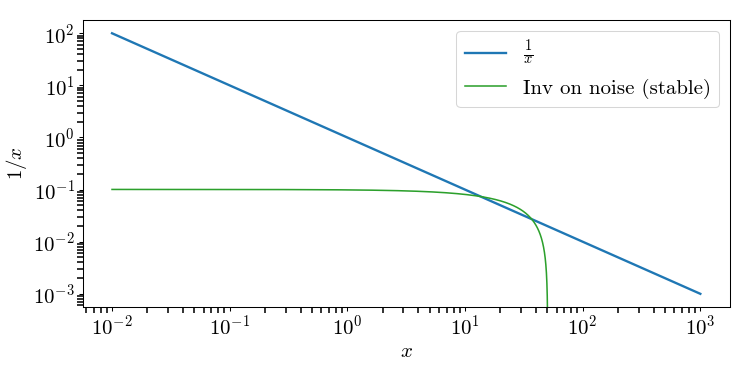

In [31]:
fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$', style = int_style)

line1, = ax.plot(xx, np.abs(poly_inv_GCR_xx[0]), color = pt.pal[2], label = 'Inv on noise (stable)')
def update1(n=0):
    line1.set_ydata(np.real(poly_inv_GCR_xx[n]))
    fig.canvas.draw_idle()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$x$', fontsize = default_style['fontsize'])
ax.set_ylabel(r'$1/x$', fontsize = default_style['fontsize'])
# ax.set_xlim((0.01, 10))
# ax.set_ylim((-0.5, 10))
plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

interact(update1, n = (1, max_itr - 1, 1))

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update2(n=0)>

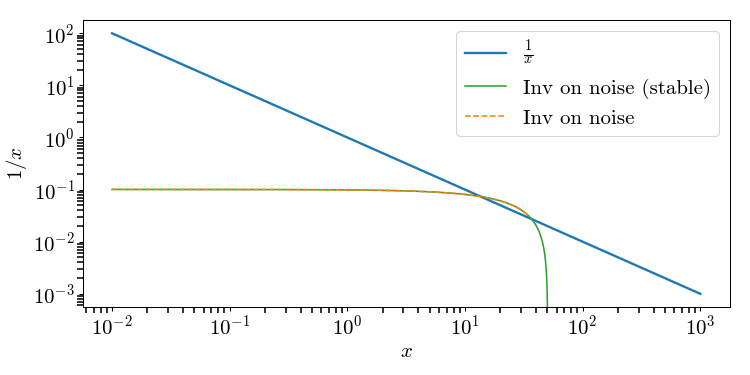

In [32]:
fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$', style = int_style)

line2, = ax.plot(xx, np.abs(poly_inv_GCR_xx[0]), color = pt.pal[2], label = 'Inv on noise (stable)')
line3, = ax.plot(xx, np.abs(poly_inv_xx[0]), color = pt.pal[1], linestyle = '--', label = 'Inv on noise')
def update2(n=0):
    line2.set_ydata(np.real(poly_inv_GCR_xx[n]))
    line3.set_ydata(np.real(poly_inv_xx[n]))
    fig.canvas.draw_idle()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$x$', fontsize = default_style['fontsize'])
ax.set_ylabel(r'$1/x$', fontsize = default_style['fontsize'])
# ax.set_xlim((0.01, 10))
# ax.set_ylim((-0.5, 10))
plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

interact(update2, n = (1, max_itr - 1, 1))

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update1(n=0)>

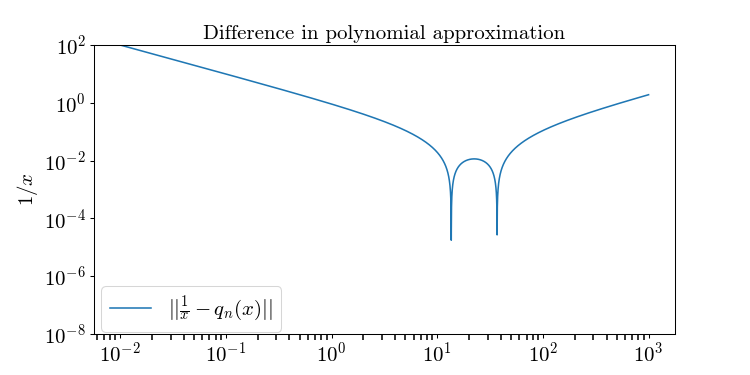

In [33]:
yy = np.abs(xx_inv - poly_inv_GCR_xx[0])

# fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$', style = int_style)
fix, axes = pt.add_subplots(style = int_style)
ax = axes[0]

line1, = ax.plot(xx, yy, color = pt.pal[0], label = r'$||\frac{1}{x} - q_n(x)||$')
def update1(n=0):
    line1.set_ydata(
        np.abs(xx_inv - poly_inv_GCR_xx[n])
    )
    fig.canvas.draw_idle()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$x$', fontsize = int_style['fontsize'])
ax.set_ylabel(r'$1/x$', fontsize = int_style['fontsize'])
ax.set_title('Difference in polynomial approximation', fontsize = int_style['fontsize'])
# ax.set_xlim((0.01, 10))
ax.set_ylim((10**-8, 100))
plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (0.34, 0.2))

interact(update1, n = (1, max_itr - 1, 1))

### Convergence in the complex plane

In [34]:
# NLAMBDA_ZX = 1000
# NLAMBDA_ZY = 600
NLAMBDA_ZX = 500
NLAMBDA_ZY = 501
# NLAMBDA_ZX = 1000
# NLAMBDA_ZY = 1001
# IM_BOUNDS = (-10, 10)
IM_BOUNDS = (-5, 5)

# zx = np.logspace(-3, 3, num = NLAMBDA_ZX)
# zy = np.linspace(-1, 1, num = NLAMBDA_ZY)

zx = np.linspace(0, 65, num = NLAMBDA_ZX)
# zx = np.logspace(-5, 3, num = NLAMBDA_ZX)
zy = np.linspace(IM_BOUNDS[0], IM_BOUNDS[1], num = NLAMBDA_ZY)

zxx, zyy = np.meshgrid(zx, zy)
zz = zxx + 1j*zyy

# Numerically unstable evaluation q_n(z)
# poly_inv_zz = [poly(zz) for poly in poly_inv]
# poly_relax_zz = [poly(zz) for poly in poly_relax]

In [35]:
# numerically stable evaluation q_n(z)
poly_inv_GCR_zz = np.zeros((max_itr, zz.shape[0], zz.shape[1]), dtype = np.complex64)
for ii, jj in itertools.product(range(zz.shape[0]), range(zz.shape[1])):
    z = zz[ii, jj]
    pz = GCRinv.eval_poly_stable(z, store_all = True)
    poly_inv_GCR_zz[:, ii, jj] = pz

/var/folders/4q/v1ykxzz94sn6ms0kkh0gm8880000gr/T/ipykernel_95588/410749113.py:6: RuntimeWarning: overflow encountered in cast
  poly_inv_GCR_zz[:, ii, jj] = pz


In [36]:
zz_inv = 1 / zz
dev = np.abs(zz_inv - poly_inv_GCR_zz)
re_dev = np.abs(np.real(zz_inv - poly_inv_GCR_zz))
im_dev = np.abs(np.imag(zz_inv - poly_inv_GCR_zz))

/var/folders/4q/v1ykxzz94sn6ms0kkh0gm8880000gr/T/ipykernel_95588/2319598387.py:1: RuntimeWarning: divide by zero encountered in divide
  zz_inv = 1 / zz
/var/folders/4q/v1ykxzz94sn6ms0kkh0gm8880000gr/T/ipykernel_95588/2319598387.py:1: RuntimeWarning: invalid value encountered in divide
  zz_inv = 1 / zz


In [37]:
largest_eig_sq = 3467.65302            # from running power method in Example_deflation_basis.cc
r = np.sqrt(largest_eig_sq)
tt = np.linspace(-0.5, 0.5, 100)
circle = r * np.exp(1j*np.pi*tt)
print(r)

58.88678136899656


In [38]:
# fig, axes = pt.add_subplots(style = int_style)
# ax = axes[0]

# cb = None
# def update0(n=0):
#     global cb
#     if cb:
#         cb.remove()
#     plot = ax.pcolormesh(zxx, zyy, np.log(dev[n]), cmap = 'hot')
#     fig.canvas.draw_idle()
#     cb = plt.colorbar(plot)

# ax.set_xscale('log')
# ax.set_xlabel(r'$Re[z]$', fontsize = default_style['fontsize'])
# ax.set_ylabel(r'$Im[z]$', fontsize = default_style['fontsize'])
# ax.set_title(r'Log deviation $\log ||z^{-1} - q_n(z)||$')

# interact(update0, n = (1, 49, 1))

In [61]:
# evals_low, ritz_low = utils.read_eval_txt(r'/Users/patrickoare/lqcd/multigrid/spectra/ckpoint_lat.4000/unprec_Nm200_Nk120_276609/evals.txt')
evals_high, ritz_high = utils.read_eval_txt(r'/Users/patrickoare/lqcd/multigrid/spectra/ckpoint_lat.4000/unprec_Nm200_Nk120_276610/evals.txt')

Eval 0 = (58.9786-2.04281e-14j), ritz estimate = 0.0155541
Eval 1 = (58.9765+2.84217e-13j), ritz estimate = 0.00448187
Eval 2 = (58.9744-7.4607e-14j), ritz estimate = 0.01035
Eval 3 = (58.9715-1.52767e-13j), ritz estimate = 0.0133615
Eval 4 = (58.9505+3.90799e-14j), ritz estimate = 0.00212533
Eval 5 = (58.9484+1.06581e-13j), ritz estimate = 0.00627779
Eval 6 = (58.9455-3.90799e-14j), ritz estimate = 0.00920732
Eval 7 = (58.945-1.45661e-13j), ritz estimate = 0.00623658
Eval 8 = (58.9196-6.75016e-14j), ritz estimate = 0.00286003
Eval 9 = (58.9189-2.59348e-13j), ritz estimate = 0.00312433
Eval 10 = (58.9148-4.66294e-14j), ritz estimate = 0.00087177
Eval 11 = (58.9147-1.7053e-13j), ritz estimate = 0.00011685
Eval 12 = (58.9104+4.26326e-14j), ritz estimate = 0.00320284
Eval 13 = (58.9102-1.27898e-13j), ritz estimate = 5.7386e-05
Eval 14 = (58.8997-2.84217e-14j), ritz estimate = 1.23127e-06
Eval 15 = (58.8994-8.17124e-14j), ritz estimate = 5.26156e-07
Eval 16 = (58.896+1.91847e-13j), ritz es

In [75]:
# preliminary eigenvalues (not yet converged!)
def parse_output(estr):
    tokens = [x.strip() for x in estr.split('\n')]
    evals = []
    for token in tokens:
        if token == '': continue
        assert token[0] == '(' and token[-1] == ')', 'Wrong token input'
        token = token[1:-1].split(',')              # token == ['re', 'im']
        evals.append(
            float(token[0]) + 1j*float(token[1])
        )
    return evals
low_re = parse_output(r"""(0.00783777644,-2.71874537e-15)
   (0.0079192746,0.00612062822)
  (0.0079192746,-0.00612062822)
 (0.00793712024,-0.00233563953)
  (0.00793712024,0.00233563953)
  (0.00824646982,-0.0109907841)
   (0.00824646982,0.0109907841)
   (0.00861008307,0.0122992181)
  (0.00861008307,-0.0122992181)
  (0.00901549137,-0.0164975382)
   (0.00901549137,0.0164975382)
    (0.00908786589,0.013649063)
  (0.00908786592,-0.0136490631)
    (0.00932132839,-0.01917476)
      (0.0093213284,0.01917476)
  (0.00943963898,0.00672590746)
 (0.00943963898,-0.00672590761)
 (0.00947556528,-0.00963808339)
  (0.00947557036,0.00963808244)
   (0.00971712635,0.0188641122)
  (0.00971712669,-0.0188641122)
   (0.0101329535,-0.0243512003)
    (0.0101329537,0.0243512003)
  (0.0102055457,-0.00866854952)
   (0.0102055605,0.00866851947)
   (0.0102084713,-0.0235018749)
    (0.0102084714,0.0235018749)
    (0.0102828836,0.0251284544)
   (0.0102828838,-0.0251284543)
   (0.0106283514,-0.0279886586)
    (0.0106283517,0.0279886585)
   (0.0112557276,-0.0308257757)
    (0.0112557276,0.0308257728)
   (0.0120972409,-0.0346510543)
    (0.0120972737,0.0346510612)
    (0.012195088,-0.0326442712)
    (0.0121953634,0.0326434231)
    (0.0123159827,0.0297379179)
    (0.012316031,-0.0297369261)
     (0.0126143009,0.032305525)
   (0.0126389863,-0.0322877545)
   (0.0132218817,-0.0368469781)
     (0.013224789,0.0368644148)
   (0.0135391639,-0.0379007734)
    (0.0135556164,0.0356576193)
     (0.0135827219,0.037854627)
   (0.0136185177,-0.0356147095)
    (0.0138049768,0.0400713149)
   (0.0138065817,-0.0400719783)
    (0.0145734003,0.0421220615)
   (0.0145779786,-0.0421210528)
   (0.0152301345,-0.0445096326)
     (0.015247355,0.0445054169)
    (0.0153733248,0.0391923418)
    (0.015402675,-0.0435156661)
    (0.0155991086,0.0435053574)
   (0.0160181923,-0.0466575339)
    (0.0160332603,0.0466585245)
     (0.016224684,0.0487127723)
   (0.0162259779,-0.0487133174)
     (0.016928365,0.0492702199)
   (0.0169439323,-0.0492627033)
    (0.0175030305,0.0516898946)
   (0.0175080515,-0.0516913035)
    (0.0184932965,0.0524590229)
    (0.0185350445,0.0561018074)
   (0.0185350772,-0.0561018069)
   (0.0185709361,-0.0524119527)
    (0.0204540459,0.0571805427)
    (0.0204665797,-0.057112475)
    (0.0204802368,0.0599531638)
   (0.0204807398,-0.0599552922)
     (0.0214487214,-0.06163077)
    (0.0214644142,0.0615257127)
    (0.0216057946,0.0604085126)
   (0.0226019007,-0.0613215768)
    (0.0226545235,0.0627182529)
     (0.0228809697,0.065248198)
   (0.0229648412,-0.0652504129)
    (0.0233359277,-0.067059599)
    (0.0233369824,0.0670582754)
    (0.0244643172,-0.069517658)
    (0.0244658854,0.0695196418)
     (0.025511661,0.0712406965)
    (0.0255239599,-0.071251055)
    (0.027432464,-0.0738350002)
    (0.0274451045,0.0737973624)
   (0.0277275673,-0.0763100197)
     (0.027727861,0.0763113213)
   (0.0283312123,-0.0485155691)
    (0.0289775522,0.0774877676)
   (0.0289940222,-0.0775046858)
    (0.0307283148,-0.081036022)
    (0.0308505576,0.0809419606)
    (0.0316573797,0.0826915223)
   (0.0324302827,-0.0842073168)
    (0.0330200345,0.0838949018)
    (0.0340544003,-0.087623664)
    (0.0340611559,0.0876184685)
     (0.034462399,0.0891898646)
   (0.0344687266,-0.0891862429)
    (0.0367297806,0.0929518128)
   (0.0367338593,-0.0929570377)
    (0.0390362168,-0.095208025)
    (0.0394215899,0.0956367196)
    (0.0405841031,0.0991356585)
   (0.0406110852,-0.0991407249)
    (0.0416386648,-0.101904903)
     (0.0416407172,0.101903502)
      (0.0453141825,0.10541979)
    (0.0457218501,-0.104950612)
     (0.0464530371,0.107778408)
    (0.0466705999,-0.107429948)
    (0.0483108813,-0.111374287)
     (0.0483423277,0.111323081)
    (0.0509751188,-0.114272971)
     (0.0515034886,0.113705698)
    (0.0541661019,-0.118619786)
     (0.0542450126,0.118813311)
    (0.0571327423,-0.123915994)""")
low_im = parse_output(r"""(1.12035276,-0.460790025)""")
high_im = parse_output(r"""(1.12034961,0.460789867)""")

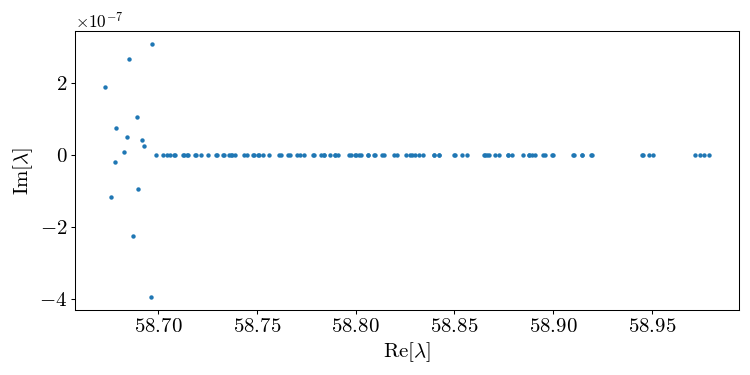

In [76]:
fig, axes = pt.add_subplots()
ax = axes[0]
# pt.scatter_1d(np.real(evals_low), np.imag(evals_low), ax = ax, col = pt.pal[0], ax_label = [r'$\mathrm{Re}[\lambda]$', r'$\mathrm{Im}[\lambda]$'])
pt.scatter_1d(np.real(evals_high), np.imag(evals_high), ax = ax, col = pt.pal[0], ax_label = [r'$\mathrm{Re}[\lambda]$', r'$\mathrm{Im}[\lambda]$'])
plt.tight_layout()
# ax.set_ylim((1.2, 1.45))

# pt.save_figure(r'/Users/patrickoare/Dropbox (Personal)/research/multigrid/plots/tmp.pdf')

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update0(n=0)>

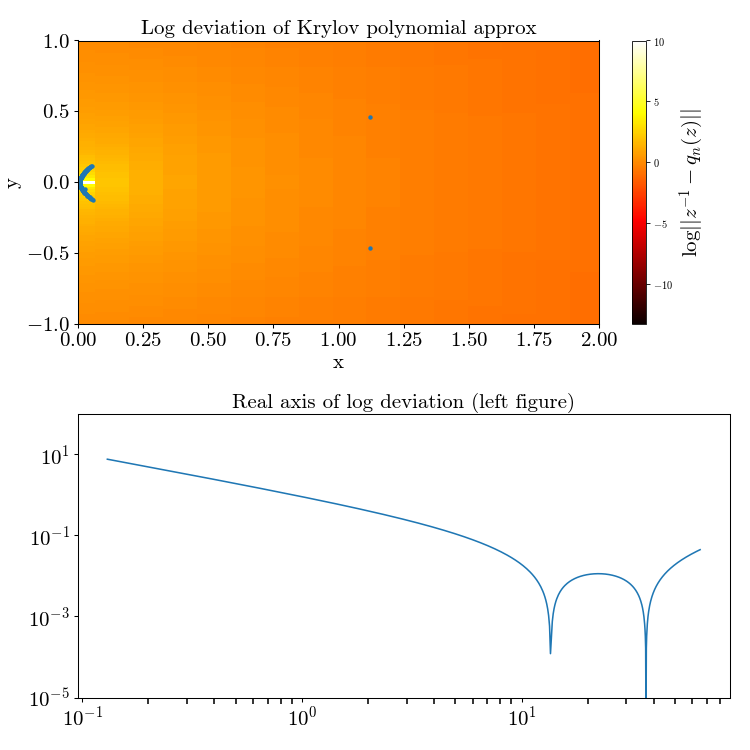

In [80]:
# CBAR_RNG = (None, None)
CBAR_RNG = (None, 10)

zy_equal_0 = zz.shape[0] // 2
x_axis = np.real(zz[zy_equal_0, :])

# fig, axes = pt.add_subplots(n_cols = 2, style = int_style)
fig, axes = pt.add_subplots(n_rows = 2, style = int_style)

cb = None

line3, = axes[1].plot(x_axis, np.log(dev[0, zy_equal_0]), color = pt.pal[0])

def update0(n=0):
    # im0.set_ydata(np.real(poly_inv_zz[n]))
    global cb
    if cb:
        cb.remove()
    
    axes[0].clear()

    # axes[0].plot(np.real(circle), np.imag(circle), color = pt.pal[2], label = r'$|\lambda_{\mathrm{max}}|$')

    # axes[0].set_xscale('log')
    axes[0].set_ylim(IM_BOUNDS)
    # ax.set_yscale('log')
    axes[0].set_xlabel(r'$Re[z]$', fontsize = int_style['fontsize'])
    axes[0].set_ylabel(r'$Im[z]$', fontsize = int_style['fontsize'])
    axes[0].set_title(r'Log deviation of Krylov polynomial approx', fontsize = int_style['fontsize'])
    axes[1].set_ylim((10**(-5), 10**2))
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_title(r'Real axis of log deviation (left figure)', fontsize = int_style['fontsize'])
    # axes[0].set_xlim((0, 2))
    axes[0].set_ylim((-2, 2))

    plot = axes[0].pcolormesh(zxx, zyy, np.log(dev[n]), cmap = 'hot', vmin = CBAR_RNG[0], vmax = CBAR_RNG[1])
    line3.set_ydata(
        dev[n, zy_equal_0]
    )
    fig.canvas.draw_idle()
    cb = plt.colorbar(plot)
    cb.ax.set_ylabel(r'$\log ||z^{-1} - q_n(z)||$', fontsize = int_style['fontsize'])

    pt.scatter_1d(np.real(low_re), np.imag(low_re), ax = axes[0], col = pt.pal[0])
    pt.scatter_1d(np.real(evals_high), np.imag(evals_high), ax = axes[0], col = pt.pal[0])
    pt.scatter_1d(np.real(low_im), np.imag(low_im), ax = axes[0], col = pt.pal[0])
    pt.scatter_1d(np.real(high_im), np.imag(high_im), ax = axes[0], col = pt.pal[0])

    axes[0].set_xlim((0, 2))
    axes[0].set_ylim((-1, 1))

# axes[0].set_xscale('log')
# # ax.set_yscale('log')
# axes[0].set_xlabel(r'$Re[z]$', fontsize = int_style['fontsize'])
# axes[0].set_ylabel(r'$Im[z]$', fontsize = int_style['fontsize'])
# axes[0].set_title(r'Log deviation of Krylov polynomial approx', fontsize = int_style['fontsize'])
# axes[1].set_ylim((10**(-5), 10**2))
# axes[1].set_xscale('log')
# axes[1].set_yscale('log')
# axes[1].set_title(r'Real axis of log deviation (left figure)', fontsize = int_style['fontsize'])

# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

interact(update0, n = (1, max_itr - 1, 1))

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update0(n=0)>

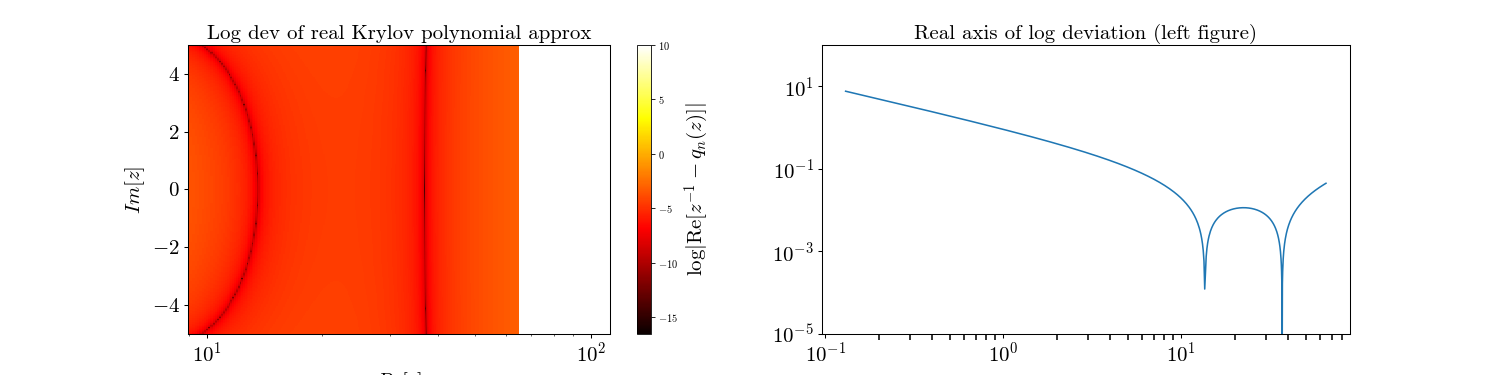

In [40]:
# CBAR_RNG = (None, None)
CBAR_RNG = (None, 10)

zy_equal_0 = zz.shape[0] // 2
x_axis = np.real(zz[zy_equal_0, :])

figRe, axesRe = pt.add_subplots(n_cols = 2, style = int_style)

cb = None

line3, = axesRe[1].plot(x_axis, np.log(re_dev[0, zy_equal_0]), color = pt.pal[0])

def update0(n=0):
    # im0.set_ydata(np.real(poly_inv_zz[n]))
    global cb
    if cb:
        cb.remove()
    
    # remove previous figure
    axesRe[0].clear()
    axesRe[0].set_xscale('log')
    axesRe[0].set_xlabel(r'$Re[z]$', fontsize = int_style['fontsize'])
    axesRe[0].set_ylabel(r'$Im[z]$', fontsize = int_style['fontsize'])
    axesRe[0].set_title(r'Log dev of real Krylov polynomial approx', fontsize = int_style['fontsize'])
    axesRe[1].set_ylim((10**(-5), 10**2))
    axesRe[1].set_xscale('log')
    axesRe[1].set_yscale('log')
    axesRe[1].set_title(r'Real axis of log deviation (left figure)', fontsize = int_style['fontsize'])

    plot = axesRe[0].pcolormesh(zxx, zyy, np.log(re_dev[n]), cmap = 'hot', vmin = CBAR_RNG[0], vmax = CBAR_RNG[1])
    line3.set_ydata(
        re_dev[n, zy_equal_0]
    )
    figRe.canvas.draw_idle()
    cb = plt.colorbar(plot)
    cb.ax.set_ylabel(r'$\log | \mathrm{Re}[z^{-1} - q_n(z)] |$', fontsize = int_style['fontsize'])

# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

interact(update0, n = (1, max_itr - 1, 1))

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update0(n=0)>

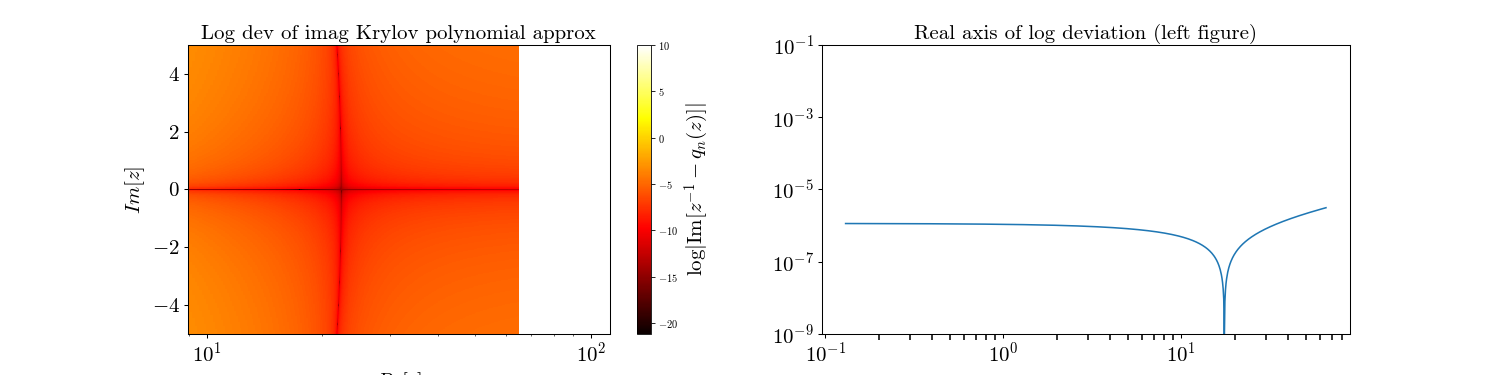

In [41]:
# CBAR_RNG = (None, None)
CBAR_RNG = (None, 10)

zy_equal_0 = zz.shape[0] // 2
x_axis = np.real(zz[zy_equal_0, :])

figRe, axesIm = pt.add_subplots(n_cols = 2, style = int_style)

cb = None

line3, = axesIm[1].plot(x_axis, np.log(im_dev[0, zy_equal_0]), color = pt.pal[0])

def update0(n=0):
    # im0.set_ydata(np.real(poly_inv_zz[n]))
    global cb
    if cb:
        cb.remove()
    
    # remove previous figure
    axesIm[0].clear()
    axesIm[0].set_xscale('log')
    axesIm[0].set_xlabel(r'$Re[z]$', fontsize = int_style['fontsize'])
    axesIm[0].set_ylabel(r'$Im[z]$', fontsize = int_style['fontsize'])
    axesIm[0].set_title(r'Log dev of imag Krylov polynomial approx', fontsize = int_style['fontsize'])
    axesIm[1].set_ylim((10**(-9), 10**(-1)))
    axesIm[1].set_xscale('log')
    axesIm[1].set_yscale('log')
    axesIm[1].set_title(r'Real axis of log deviation (left figure)', fontsize = int_style['fontsize'])

    plot = axesIm[0].pcolormesh(zxx, zyy, np.log(im_dev[n]), cmap = 'hot', vmin = CBAR_RNG[0], vmax = CBAR_RNG[1])
    line3.set_ydata(
        im_dev[n, zy_equal_0]
    )
    figRe.canvas.draw_idle()
    cb = plt.colorbar(plot)
    cb.ax.set_ylabel(r'$\log | \mathrm{Im}[z^{-1} - q_n(z)] |$', fontsize = int_style['fontsize'])

# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

interact(update0, n = (1, max_itr - 1, 1))

## Surface plots

interactive(children=(IntSlider(value=1, description='n', max=199, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update0(n=0)>

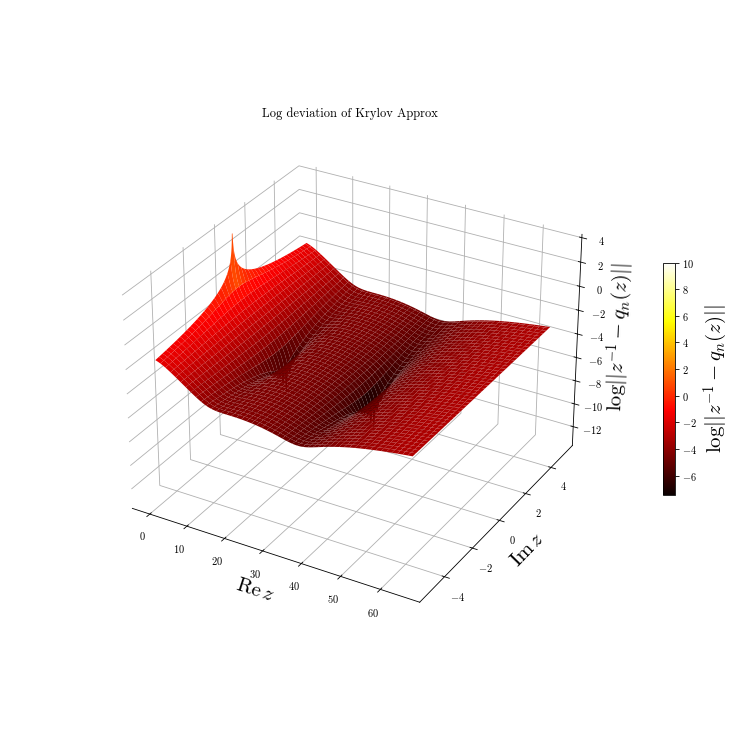

In [42]:
# fig_size = (default_style['colwidth'], default_style['colwidth'] / default_style['asp_ratio'])
fig_size = (10, 10)
fig = plt.figure(figsize = fig_size)
ax = fig.add_subplot(projection='3d')
graph = ax.plot_surface(zxx, zyy, np.log(dev[0]), cmap = 'hot')
# line3, = axes[1].plot(x_axis, np.log(dev[0, zy_equal_0]), color = pt.pal[0])

cb = None

def update0(n=0):
    # im0.set_ydata(np.real(poly_inv_zz[n]))
    global cb
    if cb:
        cb.remove()

    # ax.plot(np.real(circle), np.imag(circle), color = pt.pal[2], label = r'$|\lambda_{\mathrm{max}}|$')
    ax.clear()
    graph = ax.plot_surface(zxx, zyy, np.log(dev[n]), cmap = 'hot', vmin = CBAR_RNG[0], vmax = CBAR_RNG[1])
    cb = plt.colorbar(graph, fraction = 0.02, pad = 0.1)
    cb.ax.set_ylabel(r'$\log ||z^{-1} - q_n(z)||$', fontsize = int_style['fontsize'])

    ax.set_title(r'Log deviation of Krylov Approx')
    ax.set_xlabel(r'$\mathrm{Re}\, z$', fontsize = int_style['fontsize'])
    ax.set_ylabel(r'$\mathrm{Im}\, z$', fontsize = int_style['fontsize'])
    ax.set_zlabel(r'$\log ||z^{-1} - q_n(z)||$', fontsize = int_style['fontsize'])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # plot = axes[0].pcolormesh(zxx, zyy, np.log(dev[n]), cmap = 'hot', vmin = CBAR_RNG[0], vmax = CBAR_RNG[1])
    # line3.set_ydata(
    #     dev[n, zy_equal_0]
    # )
    fig.canvas.draw_idle()
    # cb = plt.colorbar(plot)
    # cb.ax.set_ylabel(r'$\log ||z^{-1} - q_n(z)||$', fontsize = int_style['fontsize'])

interact(update0, n = (1, max_itr - 1, 1))

### Legoland plot

In [43]:
# legoland = np.array(
#     [[ (0.000176735163255703,-3.72251903874302e-21),  (-0.000807120882231494,0.000881813381594817),   (0.000524108556458042,0.000136536759167951), (-7.51834583572551e-05,-0.000106479166161309),  (0.000327099918986412,-4.70589883397918e-05),  (-0.00017088300039637,-5.59487519605115e-05),  (-0.000117832116867013,2.43725447027001e-05),   (4.07471165571713e-05,4.33429895832436e-06), (-6.83509412140742e-06,-1.05930552638407e-05),  (-6.75463490028288e-05,1.97559337572594e-06)],
#  [(-0.000807120882231494,-0.000881813381594817),    (-0.00032453927150895,9.9360486035371e-23),  (-0.000269251698804236,0.000151142794364675),   (0.000346376897658775,0.000147969742249775),  (4.57091367955081e-05,-3.97499447287593e-05),   (1.76630904274425e-06,3.93184290195254e-05),    (5.0397384904234e-05,1.58688329851175e-05),   (8.02135144135187e-05,-3.8120994828306e-05),   (0.000128086700665489,-2.4457863231789e-06),  (0.000210873475304833,-2.04586339818195e-05)],
#  [  (0.000524108556458042,-0.00013653675916795), (-0.000269251698804236,-0.000151142794364674), (-8.89108014213137e-05,-8.31043628143071e-21), (-7.64754827333035e-05,-0.000159756529529407),  (-3.58946000238503e-05,9.86708579267272e-05),  (1.64188598522058e-05,-7.49877344098801e-05),  (-9.65866580508985e-06,6.96283127989265e-05),  (-0.000136837412777695,2.24532085221004e-05), (-0.000223902527628034,-4.27874155184009e-05),  (-0.000346080021775129,1.00777674183008e-05)],
#  [  (-7.51834583572551e-05,0.00010647916616131),  (0.000346376897658775,-0.000147969742249775),  (-7.64754827333035e-05,0.000159756529529407), (-7.46097120755817e-05,-2.76810666523024e-21),  (-0.000128211238553387,0.000284473181837847),  (-0.000210060460052976,6.97355849453535e-05), (-0.000138168498982752,-1.84348075528199e-06),  (0.000304928998618545,-6.88945742077008e-05),   (0.000374838007532765,1.93273685792426e-05),  (0.000520308427105004,-3.97261987711637e-05)],
#  [  (0.000327099918986412,4.70589883397918e-05),   (4.57091367955081e-05,3.97499447287594e-05), (-3.58946000238503e-05,-9.86708579267277e-05), (-0.000128211238553387,-0.000284473181837847),  (0.000138034626658371,-1.36405727611669e-21),   (0.000218916391419942,3.75604038311399e-05),   (8.59681745330574e-05,0.000109942325074308),  (-0.000367335170668456,5.99763222299573e-05), (-0.000460359850980984,-4.69019385592369e-05),  (-0.000692661016486347,2.58517715014341e-05)],
#  [  (-0.00017088300039637,5.59487519605114e-05),  (1.76630904274425e-06,-3.93184290195253e-05),   (1.64188598522058e-05,7.49877344098803e-05), (-0.000210060460052976,-6.97355849453531e-05),  (0.000218916391419942,-3.75604038311402e-05),   (-0.00056993868346233,3.39823599823306e-21),  (3.37980865423174e-05,-0.000163928092073669),  (0.000456593187924168,-0.000151384558544845),   (0.000645418041305325,3.35141085275056e-05),  (0.000888487987738646,-5.28896443822257e-05)],
#  [(-0.000117832116867013,-2.43725447027002e-05),   (5.0397384904234e-05,-1.58688329851173e-05), (-9.65866580508985e-06,-6.96283127989263e-05),  (-0.000138168498982752,1.84348075528188e-06),  (8.59681745330574e-05,-0.000109942325074308),    (3.37980865423174e-05,0.00016392809207367),  (0.000670420246115556,-2.42506785641641e-22),    (0.00119047295394961,-1.3810558008338e-05),   (0.000999927640120356,0.000205428430385873),    (0.00137499299984445,1.07883457099508e-05)],
#  [ (4.07471165571713e-05,-4.33429895832472e-06),   (8.02135144135187e-05,3.81209948283062e-05), (-0.000136837412777695,-2.24532085221005e-05),   (0.000304928998618545,6.88945742077008e-05), (-0.000367335170668456,-5.99763222299572e-05),   (0.000456593187924168,0.000151384558544845),    (0.00119047295394961,1.38105580083387e-05),   (-0.00212433628070471,-6.1950733512787e-22),  (-0.000964192489008583,0.000332258575674363),   (-0.00155439403837957,0.000178274661562034)],
#  [ (-6.83509412140742e-06,1.05930552638412e-05),   (0.000128086700665489,2.44578632317887e-06),  (-0.000223902527628034,4.27874155183999e-05),  (0.000374838007532765,-1.93273685792423e-05),  (-0.000460359850980984,4.69019385592373e-05),  (0.000645418041305325,-3.35141085275062e-05),  (0.000999927640120356,-0.000205428430385873), (-0.000964192489008583,-0.000332258575674363),  (-0.00290049534459463,-7.10715640892608e-21),   (-0.00253399220241035,-0.00019837994605233)],
#  [(-6.75463490028288e-05,-1.97559337572571e-06),   (0.000210873475304833,2.04586339818199e-05), (-0.000346080021775129,-1.00777674183006e-05),   (0.000520308427105004,3.97261987711639e-05), (-0.000692661016486347,-2.58517715014347e-05),   (0.000888487987738646,5.28896443822254e-05),   (0.00137499299984445,-1.07883457099513e-05),  (-0.00155439403837957,-0.000178274661562035),   (-0.00253399220241035,0.000198379946052331),    (-0.0131328555065704,9.15453312151204e-22)]]
# )
legoland = np.array(
    [[   (0.00188104434840154,4.36761412221229e-21), (-0.000520387756349604,-0.000193624238647945),   (-0.000804772428668132,0.00125597851244216),   (0.000375983000068076,0.000435510516340042),   (-3.62496446106684e-05,0.00045122285842707),   (0.000163394728868484,8.33072196937478e-05),  (-8.36534575749588e-05,0.000122977200156891),  (-0.000112200239992664,0.000152006168378795),   (4.01913247146318e-05,0.000174402795205902),  (-4.29419817675749e-05,0.000163988008938108),  (-2.45581224723389e-05,2.41749698197815e-05),  (-5.56810215061394e-05,6.75543500037726e-05),  (-4.91831481863632e-05,4.93956978490885e-05),    (-6.100898136773e-05,4.25459939274316e-05),  (-4.06002472899753e-05,3.57070136214824e-05),   (-3.05138529131581e-05,2.9978348955871e-05),  (-2.38330167665515e-05,1.61334805649033e-05),  (-4.62452361051196e-05,1.65533558031123e-05),  (-2.68631274073542e-05,1.54168108507907e-05),  (-5.0703292727034e-05,-2.55198491451139e-06)],
 [ (-0.000520387756349604,0.000193624238647945),  (0.000529184778797298,-5.35762322690623e-21), (-0.000874563098411869,-0.000330720026246658),   (0.000530273123194107,0.000138284048122083), (-0.000187046301134751,-0.000348324235890628),  (0.000159938142769733,-5.34080484873566e-05),  (1.28981506804128e-05,-0.000231736703531902),  (-0.000443404426880481,3.19785841295017e-05), (-0.000198089273440845,-8.10739235647386e-05),    (-0.00012311054074437,2.6574729864788e-05),  (-0.000149614083020415,5.49827823830053e-06),  (-8.56216580864363e-05,3.06260723746607e-05),  (-7.10316995105188e-05,3.76294020601454e-07), (-1.69875288063963e-05,-1.87588909737886e-06), (-2.40569377152366e-05,-1.08368620992523e-05), (-2.81175086201584e-05,-1.20084716010695e-05),  (-2.13198612520392e-05,1.16900288167769e-05),   (4.39839247020277e-05,-3.3233387934236e-06),   (1.87178746175357e-05,-1.0868904016063e-05),   (8.53846135641185e-05,1.78065405584852e-05)],
 [ (-0.000804772428668132,-0.00125597851244216),  (-0.000874563098411869,0.000330720026246657), (-0.000360961854168029,-4.53162094806896e-21),  (-0.000418492511037649,0.000455718567287188),   (5.36074836643301e-05,0.000243540758047925),   (6.96817814244016e-06,0.000314574420409772),  (0.000149688591904434,-0.000207727384765425), (-2.09475434999837e-06,-0.000149641256256059),   (7.79681913415287e-05,4.11441793595135e-05), (-0.000100976279352198,-4.00762375645567e-05), (-4.12522262715647e-05,-5.96587674291388e-05),  (1.59417923261649e-05,-6.68834829059871e-05),  (-2.27743237075716e-05,-4.1794496306527e-05),  (-6.7470130263322e-05,-1.62259966405533e-05), (-4.42999823106069e-05,-1.17374695655363e-05), (-2.75106041738998e-05,-1.70985158527823e-06), (-2.26739742359875e-05,-3.74374550683392e-05), (-0.000106865724478426,-1.11982657016952e-05),  (-5.71154287435235e-05,9.63394987458294e-06), (-0.000147091926628331,-3.28383132173036e-05)],
 [ (0.000375983000068076,-0.000435510516340042),  (0.000530273123194107,-0.000138284048122084), (-0.000418492511037649,-0.000455718567287188),    (0.00034611516809972,8.04661722357633e-21), (-0.000597043404097051,-4.04398238753033e-06),  (-3.18724881646292e-05,0.000243976646580608),   (0.000170097021624748,0.000124642414567077),  (2.49463013156419e-05,-5.18669438274604e-05),  (0.000187714722377411,-0.000133009205671713),   (5.13693781388327e-05,4.62405673983278e-06),  (7.67152276293636e-06,-2.29932371134571e-05),    (2.54205021591436e-05,3.5510001151344e-05),   (4.03520028634994e-05,2.02812454688674e-05),  (0.000126651546072121,-5.69220638592698e-06),  (6.56757166952127e-05,-1.38219216717107e-05),  (3.67847866316309e-05,-7.37580527347801e-06),   (3.25659512331712e-05,3.26898650776375e-05),   (0.000153834942621339,5.99549647949919e-07),   (8.01705684388014e-05,-2.1794435438145e-05),   (0.000193288752664485,4.04117343237152e-05)],
 [ (-3.62496446106684e-05,-0.00045122285842707),  (-0.000187046301134751,0.000348324235890627),  (5.36074836643301e-05,-0.000243540758047925),  (-0.000597043404097051,4.04398238753063e-06),   (2.03880043611558e-06,5.26612485464298e-21),  (0.000491855935717136,-5.57944319114666e-05), (-0.000191207841819432,-0.000157549754936359),  (-0.000329038739738386,7.77253497494605e-07),  (-0.000415078634653482,0.000109781048939589),  (-0.00019765229614126,-7.70013499028209e-05), (-0.000121542264442607,-4.86653672574314e-05), (-9.80078751319451e-05,-4.28691338082709e-06),  (-0.00010142017893134,-1.75018629317945e-05),   (-0.000171731966734624,1.7589906995475e-05),    (-0.00013070156024424,2.1344787877897e-05),  (-8.41478007964968e-05,2.57881911486359e-05), (-6.12246582850945e-05,-3.99631684057208e-05),  (-0.000199987928774342,4.00493570202655e-06),  (-0.000109915182823094,2.86805224094805e-05), (-0.000260633099351202,-4.93995167737105e-05)],
 [ (0.000163394728868484,-8.33072196937477e-05),   (0.000159938142769733,5.34080484873575e-05),  (6.96817814244016e-06,-0.000314574420409772), (-3.18724881646292e-05,-0.000243976646580608),   (0.000491855935717136,5.57944319114671e-05),  (-0.000851131220104908,2.70870519881144e-21), (-0.000148500065609516,-0.000392622972942581), (-0.000206124318851259,-9.95578069769194e-05),  (-1.47425523206793e-05,0.000132391720613363),   (0.000155582437157671,5.43799296761737e-05),  (1.27099926362492e-05,-5.30170480819534e-05),  (-3.50976816500212e-05,9.24880146390302e-05),   (3.93147101813978e-05,2.10868836000705e-05),  (0.000164856907453446,-1.41053166927422e-05),   (9.2287002710836e-05,-1.63119198719593e-05),  (5.38693828561549e-05,-1.00546539028081e-05),   (3.76871645873857e-05,4.96713659509413e-05),  (0.000225128346933877,-6.63714593209648e-07),  (0.000118428822616905,-2.29601304020653e-05),    (0.00030781695793452,5.54551271272276e-05)],
 [(-8.36534575749588e-05,-0.000122977200156891),   (1.28981506804128e-05,0.000231736703531902),   (0.000149688591904434,0.000207727384765425),  (0.000170097021624748,-0.000124642414567077),  (-0.000191207841819432,0.000157549754936359),  (-0.000148500065609516,0.000392622972942581),   (0.000308215936369644,-1.0694414501614e-21),   (0.000307344444646597,0.000207813337539869),  (-0.000186518090439962,0.000421353726066126),  (-5.19697611220668e-05,4.55904753222308e-05),   (3.19697400735206e-07,5.72901094643909e-05), (-4.01084107834049e-05,-2.32553588358379e-05),  (-7.0959861436254e-05,-1.69493015926747e-05),  (-0.000195721136272551,6.09844312820551e-05),  (-0.000114673247486713,5.38936983038462e-05),  (-6.18134144818193e-05,5.83638670720324e-05), (-4.58182753512923e-05,-4.25227207796331e-05),  (-0.000270203048820019,1.64214573805437e-05),  (-0.000143497886893473,4.02394972399296e-05), (-0.000363468561594335,-7.36373235072649e-05)],
 [(-0.000112200239992664,-0.000152006168378795),  (-0.000443404426880481,-3.1978584129502e-05),   (-2.09475434999837e-06,0.00014964125625606),   (2.49463013156419e-05,5.18669438274599e-05), (-0.000329038739738386,-7.77253497494225e-07),   (-0.000206124318851259,9.9557806976919e-05),  (0.000307344444646597,-0.000207813337539869),   (0.000206941471748266,2.52827476868565e-22), (-0.000120880320390747,-0.000170141710120792),  (-0.000612395189588722,0.000148928017684886), (-0.000202906722823828,-2.32398407675585e-05), (-7.73452855012278e-05,-7.22844024081309e-05), (-0.000133482781079051,-7.72560242234072e-05),  (-0.000286620814670196,3.15203794312203e-05),  (-0.000171138368238369,3.49839076591898e-05),   (-0.000100634542738411,2.7771985372192e-05), (-9.16962819525798e-05,-8.82433837952538e-05),   (-0.000341666246819989,1.0463616171931e-05),  (-0.000179205936889386,4.44158764744942e-05), (-0.000434473770179449,-8.37616007458438e-05)],
 [ (4.01913247146318e-05,-0.000174402795205902),  (-0.000198089273440845,8.10739235647387e-05),  (7.79681913415287e-05,-4.11441793595135e-05),   (0.000187714722377411,0.000133009205671712), (-0.000415078634653482,-0.000109781048939588), (-1.47425523206793e-05,-0.000132391720613363), (-0.000186518090439962,-0.000421353726066126),  (-0.000120880320390747,0.000170141710120793),  (7.82977846694986e-05,-3.32438051208113e-21), (-0.000473814974747483,-9.13080133393676e-05), (-7.72461484134719e-05,-3.30817845185482e-05),   (1.68696928124973e-06,6.38918002116784e-05),  (-0.000104010946007821,1.86146505175457e-05),  (-0.000325521874495199,7.74703207729886e-05),  (-0.000166972156858376,6.18923979187771e-05),  (-8.10940309280848e-05,5.36213750669607e-05), (-5.28487473352078e-05,-7.86796032594392e-05),  (-0.000383375620463923,2.85555448555133e-06),  (-0.000183480838091781,6.20286464611999e-05),  (-0.00050259339275683,-9.15904309095216e-05)],
 [(-4.29419817675749e-05,-0.000163988008938108),   (-0.00012311054074437,-2.6574729864788e-05),  (-0.000100976279352198,4.00762375645566e-05),  (5.13693781388327e-05,-4.62405673983295e-06),   (-0.00019765229614126,7.70013499028205e-05),  (0.000155582437157671,-5.43799296761744e-05), (-5.19697611220668e-05,-4.55904753222304e-05), (-0.000612395189588722,-0.000148928017684886),  (-0.000473814974747483,9.13080133393675e-05),  (-3.00016945023768e-05,1.11807243865069e-21),   (0.000167965286061431,3.98964078889624e-06),  (0.000283719955214843,-3.69946477998128e-05),  (3.57244063238798e-05,-1.29548471710151e-05),  (-0.000341563473222565,8.29024554797709e-05),  (-0.000129604915047759,8.33925020153815e-05),  (-3.05453567985582e-05,7.69645170042702e-05), (-7.39908519901144e-05,-9.88506003916333e-05),  (-0.000439631375534592,1.53221675616278e-05),   (-0.000220486944174332,6.6897016471354e-05), (-0.000591211301279842,-0.000124443350725257)],
 [(-2.45581224723389e-05,-2.41749698197815e-05), (-0.000149614083020415,-5.49827823830065e-06),  (-4.12522262715647e-05,5.96587674291385e-05),   (7.67152276293636e-06,2.29932371134565e-05),  (-0.000121542264442607,4.86653672574314e-05),   (1.27099926362492e-05,5.30170480819533e-05),  (3.19697400735206e-07,-5.72901094643913e-05),  (-0.000202906722823828,2.32398407675586e-05),  (-7.72461484134719e-05,3.30817845185487e-05),  (0.000167965286061431,-3.98964078889611e-06),  (-0.000420930536034298,5.17687272096843e-21),  (0.000319686602774587,-0.000115066060266189),  (-0.000115844151427364,-9.4160810150738e-05),  (-0.000497737472999279,3.00442986552904e-05),  (-0.000206490467885338,4.48727229029923e-05),  (-7.50993764731614e-05,8.01370749744687e-05),  (-6.1580422159655e-05,-0.000134057990499585),  (-0.000538705471823905,2.67948890295416e-05),  (-0.000270715039992939,7.99302797013176e-05),  (-0.000710693945138494,-0.00016256580856759)],
 [(-5.56810215061394e-05,-6.75543500037726e-05), (-8.56216580864363e-05,-3.06260723746604e-05),    (1.59417923261649e-05,6.6883482905987e-05),  (2.54205021591436e-05,-3.55100011513437e-05),  (-9.80078751319451e-05,4.28691338082707e-06), (-3.50976816500212e-05,-9.24880146390303e-05),  (-4.01084107834049e-05,2.32553588358381e-05),  (-7.73452855012278e-05,7.22844024081306e-05),  (1.68696928124973e-06,-6.38918002116787e-05),   (0.000283719955214843,3.69946477998135e-05),   (0.000319686602774587,0.000115066060266188),  (-0.000255788360011566,2.24539998694903e-21), (-0.000604569861103857,-0.000428548286304738),  (-0.000780627933095464,0.000225968055228552),  (-0.000564805013255337,1.88869284918665e-05),  (-0.000169117374908493,8.70499958544715e-05), (-0.000151994008518727,-0.000129847573951841), (-0.000692942310552325,-2.00593155062297e-05),  (-0.000346007015398797,5.35373783918897e-05),  (-0.00080405173620705,-0.000158792879953468)],
 [(-4.91831481863632e-05,-4.93956978490885e-05), (-7.10316995105188e-05,-3.76294020601613e-07),  (-2.27743237075716e-05,4.17944963065267e-05),  (4.03520028634994e-05,-2.02812454688673e-05),   (-0.00010142017893134,1.75018629317946e-05),  (3.93147101813978e-05,-2.10868836000702e-05),   (-7.0959861436254e-05,1.69493015926744e-05),  (-0.000133482781079051,7.72560242234068e-05), (-0.000104010946007821,-1.86146505175456e-05),   (3.57244063238798e-05,1.29548471710149e-05),   (-0.000115844151427364,9.4160810150738e-05),  (-0.000604569861103857,0.000428548286304738),  (9.47849046411845e-05,-2.77971123850977e-21),  (-0.00138019207277454,-0.000124731274357284),   (-0.00049133419159956,0.000208457788341759),   (-9.63611771079723e-05,0.00013170929523352),   (3.46704379202885e-05,-0.00022104834640535),  (-0.000799783350103116,-5.4724640054646e-06),  (-0.000352171810690386,0.000121685007257066), (-0.000866320261332262,-0.000217012251723012)],
 [  (-6.100898136773e-05,-4.25459939274315e-05),  (-1.69875288063963e-05,1.87588909737884e-06),   (-6.7470130263322e-05,1.62259966405532e-05),     (0.000126651546072121,5.692206385927e-06), (-0.000171731966734624,-1.75899069954749e-05),   (0.000164856907453446,1.41053166927426e-05), (-0.000195721136272551,-6.09844312820551e-05), (-0.000286620814670196,-3.15203794312199e-05), (-0.000325521874495199,-7.74703207729884e-05), (-0.000341563473222565,-8.29024554797714e-05), (-0.000497737472999279,-3.00442986552899e-05), (-0.000780627933095464,-0.000225968055228552),   (-0.00138019207277454,0.000124731274357283),   (0.00111889205405194,-3.24085501892438e-21),    (0.000640188122852882,0.00102548470742122),     (0.0002127634048749,0.000244115409500497),  (0.000355978288672723,-6.46675913234657e-05),  (-0.000669347313038202,8.08795358216468e-05),  (-0.000358323615293042,-1.4414873238548e-06),  (-0.00102258134696344,-0.000248378801195647)],
 [(-4.06002472899753e-05,-3.57070136214826e-05),  (-2.40569377152366e-05,1.08368620992525e-05),  (-4.42999823106069e-05,1.17374695655365e-05),   (6.56757166952127e-05,1.38219216717109e-05),  (-0.00013070156024424,-2.13447878778968e-05),    (9.2287002710836e-05,1.63119198719592e-05), (-0.000114673247486713,-5.38936983038464e-05), (-0.000171138368238369,-3.49839076591898e-05), (-0.000166972156858376,-6.18923979187768e-05), (-0.000129604915047759,-8.33925020153815e-05), (-0.000206490467885338,-4.48727229029923e-05), (-0.000564805013255337,-1.88869284918662e-05),   (-0.00049133419159956,-0.00020845778834176),   (0.000640188122852882,-0.00102548470742122),  (-0.00248241010440642,-1.76852997955778e-21),  (-0.000559768566566349,0.000485077253713556), (-3.39514346453843e-05,-0.000505240643172405),    (-0.0011517779995118,0.000192316114042211),   (-0.000435490538748645,0.00015919585170994),  (-0.00137584829367857,-0.000201361698530646)],
 [(-3.05138529131581e-05,-2.99783489558711e-05),  (-2.81175086201584e-05,1.20084716010695e-05),  (-2.75106041738998e-05,1.70985158527826e-06),   (3.67847866316309e-05,7.37580527347789e-06), (-8.41478007964968e-05,-2.57881911486359e-05),   (5.38693828561549e-05,1.00546539028077e-05), (-6.18134144818193e-05,-5.83638670720322e-05), (-0.000100634542738411,-2.77719853721921e-05), (-8.10940309280848e-05,-5.36213750669609e-05), (-3.05453567985582e-05,-7.69645170042692e-05), (-7.50993764731614e-05,-8.01370749744687e-05), (-0.000169117374908493,-8.70499958544714e-05), (-9.63611771079723e-05,-0.000131709295233519),    (0.0002127634048749,-0.000244115409500497), (-0.000559768566566349,-0.000485077253713556),    (-0.0020553129303213,5.58089449381996e-21),  (-3.52743743571174e-05,8.15440789218417e-05),   (-0.00180080880284703,0.000208594042481202),  (-0.000911269682870996,0.000143614297963031),  (-0.00168632508545047,-0.000289541035222573)],
 [(-2.38330167665515e-05,-1.61334805649031e-05), (-2.13198612520392e-05,-1.16900288167771e-05),  (-2.26739742359875e-05,3.74374550683392e-05),  (3.25659512331712e-05,-3.26898650776371e-05),  (-6.12246582850945e-05,3.99631684057211e-05),  (3.76871645873857e-05,-4.96713659509412e-05),   (-4.58182753512923e-05,4.2522720779633e-05),  (-9.16962819525798e-05,8.82433837952537e-05),  (-5.28487473352078e-05,7.86796032594396e-05),  (-7.39908519901144e-05,9.88506003916331e-05),   (-6.1580422159655e-05,0.000134057990499585),  (-0.000151994008518727,0.000129847573951841),    (3.46704379202885e-05,0.00022104834640535),   (0.000355978288672723,6.46675913234671e-05),  (-3.39514346453843e-05,0.000505240643172405), (-3.52743743571174e-05,-8.15440789218418e-05),  (0.000742576678855429,-2.49118117185536e-22),   (-0.00184321079554148,-0.00187244164153245),   (-0.000415146391526695,8.2206819670952e-05),  (-0.00209434906943317,-0.000371439179852473)],
 [(-4.62452361051196e-05,-1.65533558031126e-05),   (4.39839247020277e-05,3.32333879342354e-06),  (-0.000106865724478426,1.11982657016957e-05),  (0.000153834942621339,-5.99549647950054e-07), (-0.000199987928774342,-4.00493570202671e-06),   (0.000225128346933877,6.63714593209824e-07), (-0.000270203048820019,-1.64214573805434e-05), (-0.000341666246819989,-1.04636161719315e-05),  (-0.000383375620463923,-2.8555544855509e-06), (-0.000439631375534592,-1.53221675616274e-05), (-0.000538705471823905,-2.67948890295409e-05),  (-0.000692942310552325,2.00593155062295e-05),  (-0.000799783350103116,5.47246400546563e-06), (-0.000669347313038202,-8.08795358216458e-05),   (-0.0011517779995118,-0.000192316114042212),  (-0.00180080880284703,-0.000208594042481202),    (-0.00184321079554148,0.00187244164153245),   (-0.0102922015881939,-6.20948327082737e-21),  (-3.89340553075255e-05,0.000801222240273803),    (-0.00225678801879749,-0.0012543943124036)],
 [(-2.68631274073542e-05,-1.54168108507905e-05),   (1.87178746175357e-05,1.08689040160629e-05), (-5.71154287435235e-05,-9.63394987458309e-06),   (8.01705684388014e-05,2.17944354381448e-05), (-0.000109915182823094,-2.86805224094804e-05),   (0.000118428822616905,2.29601304020659e-05),   (-0.000143497886893473,-4.023949723993e-05), (-0.000179205936889386,-4.44158764744945e-05), (-0.000183480838091781,-6.20286464612003e-05), (-0.000220486944174332,-6.68970164713535e-05), (-0.000270715039992939,-7.99302797013179e-05), (-0.000346007015398797,-5.35373783918896e-05), (-0.000352171810690386,-0.000121685007257066),  (-0.000358323615293042,1.44148732385453e-06),  (-0.000435490538748645,-0.00015919585170994),  (-0.000911269682870996,-0.00014361429796303), (-0.000415146391526695,-8.22068196709525e-05), (-3.89340553075255e-05,-0.000801222240273803),    (-0.0055299328856591,4.49516004135282e-21),   (-0.00314311892985428,-0.00136180121597918)],
 [  (-5.0703292727034e-05,2.55198491451113e-06),  (8.53846135641185e-05,-1.78065405584857e-05),  (-0.000147091926628331,3.28383132173041e-05),  (0.000193288752664485,-4.04117343237151e-05),  (-0.000260633099351202,4.93995167737111e-05),   (0.00030781695793452,-5.54551271272268e-05),  (-0.000363468561594335,7.36373235072651e-05),  (-0.000434473770179449,8.37616007458444e-05),   (-0.00050259339275683,9.15904309095204e-05),  (-0.000591211301279842,0.000124443350725257),   (-0.000710693945138494,0.00016256580856759),   (-0.00080405173620705,0.000158792879953468),  (-0.000866320261332262,0.000217012251723011),   (-0.00102258134696344,0.000248378801195649),   (-0.00137584829367857,0.000201361698530648),   (-0.00168632508545047,0.000289541035222573),   (-0.00209434906943317,0.000371439179852472),     (-0.00225678801879749,0.0012543943124036),    (-0.00314311892985428,0.00136180121597918),    (-0.0376122440303937,1.81628599516739e-22)]]
)
legoland = legoland[:, :, 0] + 1j*legoland[:, :, 1]

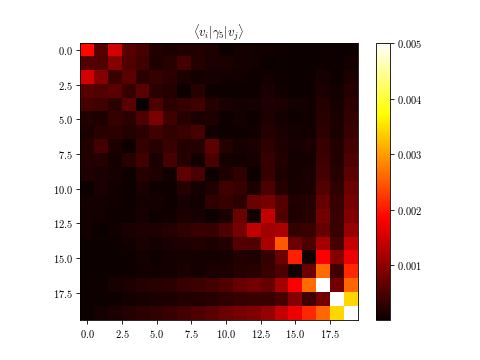

In [44]:
plt.figure()
plt.imshow(np.abs(legoland), cmap = 'hot', vmax = 0.005)
plt.title(r'$\langle v_i | \gamma_5 | v_j \rangle$')
plt.colorbar()

### Scratch work

In [45]:
# c_inv_xx = xx * c_approx(xx)              # equals 1 where this is a good approx
# zeta = c_inv_xx[20]           # ~ plateau value

# # fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$')

# # pt.plot_1d_data(xx, np.real(s_poly_orig), ax = ax, col = pt.pal[1], linestyle = '--', fn_label = r'Standard')
# fig, ax = pt.plot_1d_data(xx, np.real(c_inv_xx / zeta), col = pt.pal[2], linestyle = ':', fn_label = r'$\frac{1}{\zeta}xq_n(x)$', ax_label = [r'$x$', r'$x q_n(x)$'], title = r'$10^\mathrm{th}$ order Krylov approximation')

# pt.add_line(ax, 1.0, orientation = 'h', c = pt.pal[3], label = '1')

# # ax.set_ylim((1e-5, 10))

# ax.set_yscale('log')
# ax.set_xscale('log')
# # ax.set_xlim((0.01, 10))

# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

In [46]:
# # c_response = np.abs(1. - xx * c_approx(xx))
# c_response = 1. - xx * c_approx(xx) / zeta

# fig, ax = pt.plot_1d_data(xx, xx_inv, col = pt.pal[0], fn_label = r'$\frac{1}{x}$')

# pt.add_line(ax, 0, 'h', c = pt.pal[3], label = '0')

# pt.plot_1d_data(xx, np.real(s_poly_orig), ax = ax, col = pt.pal[1], linestyle = '--', fn_label = r'Standard')
# pt.plot_1d_data(xx, np.real(c_response), ax = ax, col = pt.pal[2], linestyle = ':', fn_label = r'Christoph', ax_label = [r'$x$', r'$\frac{1}{x}$'], title = r'$10^\mathrm{th}$ order Krylov approximation')

# # ax.set_yscale('symlog')
# ax.set_xscale('log')
# # ax.set_xlim((0.01, 10))
# # ax.set_ylim((-0.5, 10))
# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

In [47]:
# tmpF = '/Users/patrickoare/Dropbox (MIT)/research/multigrid/gcr_coeffs/run1/invert_5.xml'
# tree = ET.parse(tmpF)
# root = tree.getroot()
# xml_data = root[0][0]

In [48]:
# root[0][2].tag

In [49]:
# cc[1:-1].split(',')
# def xml_to_complex(z):
#     """ Converts an XML string of the form '(a,b)' to a complex number z = a + 1j*b. """
#     tokens = z[1:-1].split(',')
#     return float(tokens[0]) + 1j * float(tokens[1])
# [xml_to_complex(cc), xml_to_complex(root[0][0][-1][4].text)]

In [50]:
# for z in root[0][0][4]:
#     print(xml_to_complex(z.text))

In [51]:
# cc = root[0][0][-1][3].text

Next steps: 
- Precise GCR polynomial (like CG)
- Write down exactly what's going on (especially with the extra power of $D$ the initial resid gets in Christoph's case)
- Plot complex coefficients, make a surface plot of the approx to 1/x in the complex plane
- Measure nulliness of vectors as we go. 
    - Check to see at what order of $D$ things start to converge: Peter thinks it'll be an extra power of $D$ compared to what we have in the Christoph case, since it's an additional application of $D$ on the initial resid.